Для любых пар изображений которые имеют общее поле зрения (две фотографии сделанные с телефона который был повернут на определенный угол - любой лишь бы было 20+% перекрытия)
Рассчитать матрицу афинного преобразования из одной системы координат в другую. Выполнить разложение данной матрицы и посчитать явно угол поворота, вектор переноса и скалирования. 
Выполнить обратное преобразование - получить афинную матрицу заново. 

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [4]:
def extract_features(image, detector='sift', mask=None):

    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [3]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [5]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

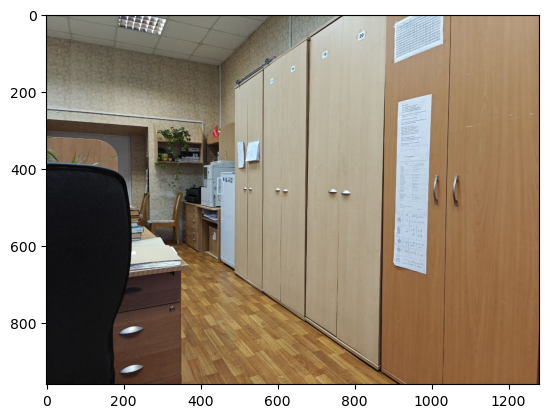

In [51]:
# Загружаем наши изображения
input_img0 = cv2.imread("photo_1.jpg")
img0 = cv2.cvtColor(input_img0,cv2.COLOR_BGR2RGB)
input_img1 = cv2.imread("photo_2.jpg")
img1 = cv2.cvtColor(input_img1,cv2.COLOR_BGR2RGB)
plt.imshow(img0)

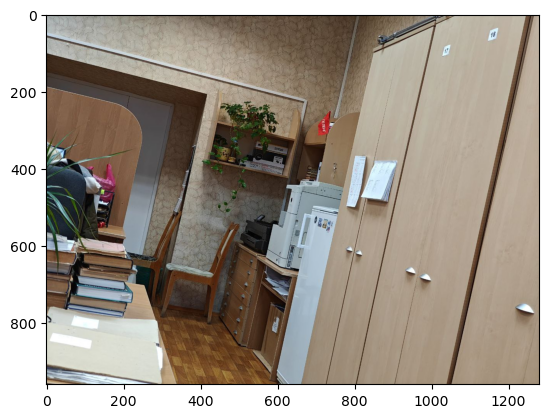

In [50]:
plt.imshow(img1)

In [21]:
# Добавляем размытие 
blurred = cv2.GaussianBlur(img0, (11,11),0)
img0 = cv2.addWeighted(img0, 2, blurred, -1, 0)    
blurred = cv2.GaussianBlur(img1, (11,11),0)
img1 = cv2.addWeighted(img1, 2, blurred, -1, 0)

In [23]:
#Функция которая уменьшает размер для ускорения оптического потока
def processing_max_dim(frame_resize, processing_max_dim): 
        
    height = frame_resize.shape[0]
    width = frame_resize.shape[1]
    max_dim_size = max(height, width);
    cof = 0
    if (max_dim_size > processing_max_dim):

        if (height > width):
            width_s = width * (processing_max_dim/ height);
            cof = processing_max_dim/ height
            frame_resize = cv2.resize(frame_resize, (int(width_s), int(processing_max_dim)));
        
        else:
        
            height_s = height * (processing_max_dim / width);
            cof = processing_max_dim / width
            
            frame_resize = cv2.resize(frame_resize, (int(processing_max_dim), int(height_s)));

    return frame_resize, cof 

In [24]:
img0, cof = processing_max_dim(img0,450)
img1, cof = processing_max_dim(img1,450)

In [19]:
# Отобразить точки
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    # Убираем оси
    plt.axis('off')

    # Сохраняем график в файл
    plt.savefig('plot_without_axes.png', bbox_inches='tight', pad_inches=0)

Number of matches before filtering: 1612
Number of matches after filtering: 28


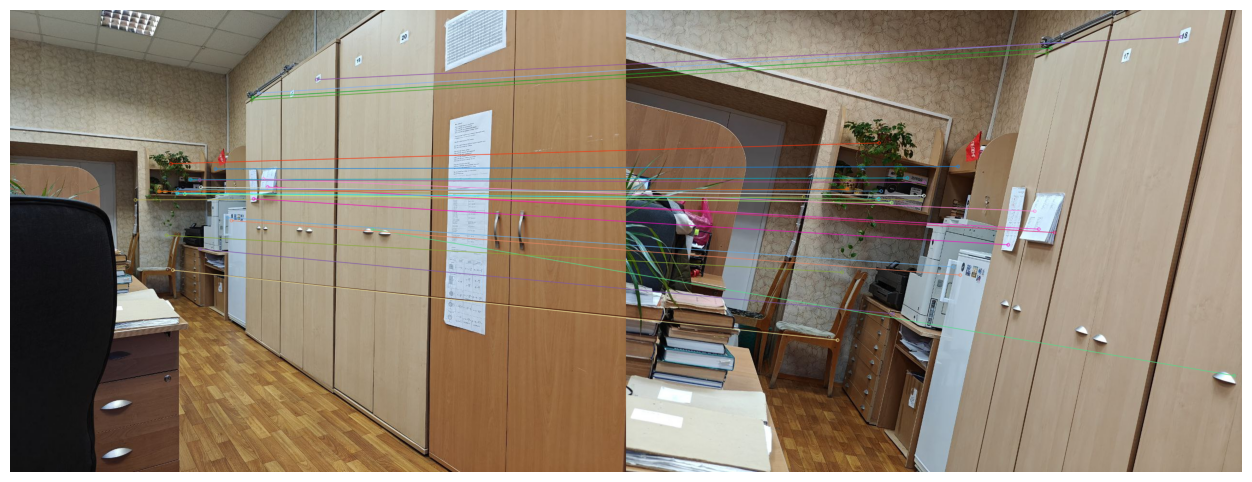

In [32]:
kp0, des0 = extract_features(img0, 'sift')
kp1, des1 = extract_features(img1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.28)
print('Number of matches after filtering:', len(matches))
visualize_matches(img0, kp0, img1, kp1, matches)

In [33]:
src_pts = np.float32([kp0[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

In [34]:
def estimate_partial_transform(cur_matched_kp, prev_matched_kp ,method):
    """
    
    :param matched_keypoints: output of match_keypoints util function; tuple of (cur_matched_kp, prev_matched_kp)
    :return: transform as list of [dx, dy, da]
    """
    transform = cv2.estimateAffine2D(np.array(prev_matched_kp),
                                           np.array(cur_matched_kp),method=method)[0] #Тут как бы можно играться с тем как будут фильтроватся точки 
                                                                                          #cv2.LMEDS один из параметров который напрямую влияет  
    #print(transform)    
    if transform is not None:
        # translation x
        dx = transform[0, 2]
        # translation y
        dy = transform[1, 2]
        # rotation
        da = np.arctan2(transform[1, 0], transform[0, 0])
    else:
        dx = dy = da = 0

    return [dx, dy, da], transform

In [36]:
m , M = estimate_partial_transform(src_pts,dst_pts, cv2.LMEDS)
m

[12.076921963188932, 230.41778705954223, -0.18393070663889527]

In [37]:
M

array([[ 5.45813452e-01,  1.24099023e-01,  1.20769220e+01],
       [-1.01539489e-01,  5.18228372e-01,  2.30417787e+02]])

In [38]:
# Матрица афинного преобразования
afine_transform_matrix =  np.append(M,np.array([0,0,1])).reshape(3,3)
afine_transform_matrix

array([[ 5.45813452e-01,  1.24099023e-01,  1.20769220e+01],
       [-1.01539489e-01,  5.18228372e-01,  2.30417787e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [39]:
def decompose_affine_matrix(affine):
    """
    Decompose an affine matrix into rotation, translation, and scaling components.

    Args:
        affine (numpy.ndarray): A 3x3 affine matrix.

    Returns:
        tuple: A tuple containing the rotation, translation, and scaling matrices.
    """
    if affine.shape != (3, 3) or affine.dtype != np.float64:
        raise ValueError("Invalid input matrix. Must be a 3x3 double matrix.")

    R = affine[:2, :2]
    U, W, Vt = np.linalg.svd(R)

    rotation = np.dot(U, Vt)
    scaling = np.diag(W)
    translation = affine[:2, 2:]

    return rotation, translation, scaling

In [40]:
rotation, translation, scaling = decompose_affine_matrix(np.linalg.inv(afine_transform_matrix))
print(f"rotation = {rotation}, translation = {translation}, scaling = {scaling}")

rotation = [[ 0.97824669 -0.20744497]
 [ 0.20744497  0.97824669]], translation = [[  75.59821215]
 [-429.8135633 ]], scaling = [[1.90101827 0.        ]
 [0.         1.78040773]]


In [41]:
def recompose_affine_matrix(rotation, translation, scaling):
    """
    Recompose an affine matrix from rotation, translation, and scaling components.

    Args:
        rotation (numpy.ndarray): A 2x2 rotation matrix.
        translation (numpy.ndarray): A 2x1 translation vector.
        scaling (numpy.ndarray): A 2x2 scaling matrix.

    Returns:
        numpy.ndarray: The recomposed 3x3 affine matrix.
    """
    # Combine rotation and scaling
    rotation_scaling = np.dot(rotation, scaling)
    
    # Create the 3x3 affine matrix
    affine = np.eye(3)
    affine[:2, :2] = rotation_scaling
    affine[:2, 2] = translation.flatten()
    
    return affine

In [42]:
recompose_affine_matrix(rotation, translation, scaling )

array([[ 1.85966483e+00, -3.69336633e-01,  7.55982122e+01],
       [ 3.94356682e-01,  1.74167797e+00, -4.29813563e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

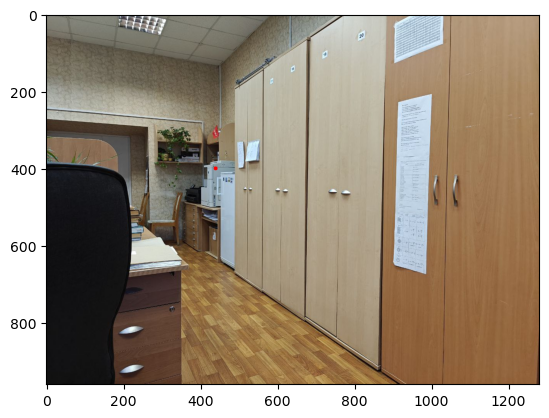

In [52]:
original_image = cv2.circle(img0, (int(440),int(400)), 5, (255, 0, 0), -1)
plt.imshow(original_image)

In [43]:
def get_angle(rotation):
    return np.arctan2(rotation[1, 0], rotation[0, 0])
def get_scale(scaling):
    return np.sqrt(scaling[0, 0] ** 2 + scaling[1, 1] ** 2)
def get_translation(translation):
    return translation
def get_angle_degrees(rotation):
    return np.degrees(np.arctan2(rotation[1, 0], rotation[0, 0]))

In [44]:
angle = get_angle_degrees(rotation)
scale = get_scale(scaling)
translation = get_translation(translation)

print("Угол:", angle)
print("Коэффициент увеличения:", scale)
print("Перевод:", translation)

Угол: 11.972662963467213
Коэффициент увеличения: 2.604557960579635
Перевод: [[  75.59821215]
 [-429.8135633 ]]


In [5]:
# Trackbar

import numpy as np
import cv2 as cv

def nothing(x):
    #print(x)
    pass

# Create a black image, a window
img = np.zeros((300,512,3), np.uint8)
cv.namedWindow('image')

cv.createTrackbar('B', 'image', 0, 255, nothing)
cv.createTrackbar('G', 'image', 0, 255, nothing)
cv.createTrackbar('R', 'image', 0, 255, nothing)

switch = '0 : OFF\n 1 : ON'
cv.createTrackbar("On/Off", 'image', 0, 1, nothing)

while(1):
    cv.imshow('image',img)
    if cv2.waitKey(30) & 0xFF == ord('q'):
          break

    b = cv.getTrackbarPos('B', 'image')
    g = cv.getTrackbarPos('G', 'image')
    r = cv.getTrackbarPos('R', 'image')
    s = cv.getTrackbarPos("On/Off", 'image')

    if s == 0:
       img[:] = 0
    else:
        img[:] = [b, g, r]


cv.destroyAllWindows()

"\nview rawpython_opencv_trackbar_example1.py hosted with ❤ by GitHub\nimport numpy as np\nimport cv2 as cv\n\ndef nothing(x):\n    print(x)\n\n# Create a black image, a window\ncv.namedWindow('image')\n\ncv.createTrackbar('CP', 'image', 10, 400, nothing)\n\nswitch = 'color/gray'\ncv.createTrackbar(switch, 'image', 0, 1, nothing)\n\nwhile(1):\n    img = cv.imread('lena.jpg')\n    pos = cv.getTrackbarPos('CP', 'image')\n    font = cv.FONT_HERSHEY_SIMPLEX\n    cv.putText(img, str(pos), (50, 150), font, 6, (0, 0, 255), 10)\n\n    k = cv.waitKey(1) & 0xFF\n    if k == 27:\n        break\n\n    s = cv.getTrackbarPos(switch, 'image')\n\n    if s == 0:\n       pass\n    else:\n       img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)\n\n    img = cv.imshow('image',img)\n\ncv.destroyAllWindows()\n"